# 05 — Monte Carlo Improved Search (Simulated Annealing)

**Objectif :** améliorer la recherche Monte Carlo en exploitant une exploration locale :
- partir d’un planning initial,
- générer des voisins (swap / move),
- accepter toujours les améliorations,
- accepter parfois les dégradations (probabilité \(\exp(-\Delta/T)\)) pour sortir des minima locaux.

On compare ensuite la convergence à **Monte Carlo Random Search**.


In [2]:
import json
import numpy as np
import random
import time
import math
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path("/content")
INSTANCES_DIR = BASE_DIR / "data" / "instances"
RESULTS_DIR   = BASE_DIR / "data" / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("INSTANCES_DIR:", INSTANCES_DIR)
print("RESULTS_DIR:", RESULTS_DIR)


INSTANCES_DIR: /content/data/instances
RESULTS_DIR: /content/data/results


## 1) Chargement de l’instance et fonctions utilitaires

On réutilise :
- simulation
- score (métriques)
- génération aléatoire de solution

Puis on définit des **mouvements de voisinage** (swap/move) et le recuit simulé.


In [3]:
def load_instance(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def is_valid_solution(solution, n_jobs):
    flat = [job for seq in solution for job in seq]
    return (len(flat) == n_jobs) and (sorted(flat) == list(range(n_jobs)))

def simulate(instance, solution):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]
    p = instance["processing_times"]
    releases = instance.get("releases", None)
    if releases is None:
        releases = [0.0] * n_jobs

    start = [0.0] * n_jobs
    end = [0.0] * n_jobs
    machine_time = [0.0] * n_machines

    for k in range(n_machines):
        t = 0.0
        for j in solution[k]:
            t = max(t, float(releases[j]))
            start[j] = t
            t += float(p[j][k])
            end[j] = t
        machine_time[k] = t

    Cmax = max(end) if end else 0.0
    return {"start": start, "end": end, "machine_time": machine_time, "Cmax": Cmax}

def compute_score(instance, sim, alpha=1.0, beta=0.2, gamma=0.0):
    end = sim["end"]
    Cmax = float(sim["Cmax"])

    deadlines = instance.get("deadlines", None)
    weights = instance.get("weights", None)

    sumT = 0.0
    sumWT = 0.0

    if deadlines is not None:
        for j in range(instance["n_jobs"]):
            tj = max(0.0, float(end[j]) - float(deadlines[j]))
            sumT += tj
            if weights is not None:
                sumWT += float(weights[j]) * tj

    score = alpha * Cmax + beta * sumT + gamma * sumWT
    return score, {"Cmax": Cmax, "sumT": sumT, "sumWT": sumWT, "score": score}


In [4]:
instance_path = "/content/data/instances/instance_50jobs_5machines.json"
instance = load_instance(instance_path)

print("Loaded:", instance["name"])
print("n_jobs:", instance["n_jobs"], "| n_machines:", instance["n_machines"])
print("deadlines:", instance.get("deadlines") is not None)


Loaded: instance_50jobs_5machines
n_jobs: 50 | n_machines: 5
deadlines: True


## 2) Solutions initiales

Le recuit simulé démarre d’une solution initiale.  
Dans un premier temps, on peut partir d’un planning aléatoire.

> Remarque : on pourra aussi partir d’une heuristique gloutonne (SPT/EDD) pour accélérer la convergence.


In [5]:
def random_solution(instance, rng):
    n_jobs = instance["n_jobs"]
    n_machines = instance["n_machines"]

    jobs = list(range(n_jobs))
    rng.shuffle(jobs)

    sol = [[] for _ in range(n_machines)]
    for j in jobs:
        k = rng.randrange(n_machines)
        sol[k].append(j)

    for k in range(n_machines):
        rng.shuffle(sol[k])

    return sol


## 3) Voisinages (mouvements locaux)

On utilise des mutations simples pour explorer l’espace des plannings :

- **Swap intra-machine** : échanger deux tâches sur une même machine
- **Move inter-machines** : déplacer une tâche d’une machine vers une autre (à une position aléatoire)
- **Swap inter-machines** : échanger une tâche entre deux machines

Ces opérateurs conservent la validité de la solution (chaque tâche reste unique).


In [6]:
def swap_intra(sol, rng):
    new = [seq[:] for seq in sol]
    k = rng.randrange(len(new))
    if len(new[k]) < 2:
        return new
    i, j = rng.sample(range(len(new[k])), 2)
    new[k][i], new[k][j] = new[k][j], new[k][i]
    return new

def move_inter(sol, rng):
    new = [seq[:] for seq in sol]
    ks = [k for k in range(len(new)) if len(new[k]) > 0]
    if not ks:
        return new
    ka = rng.choice(ks)
    idx = rng.randrange(len(new[ka]))
    job = new[ka].pop(idx)

    kb = rng.randrange(len(new))
    pos = rng.randrange(len(new[kb]) + 1)
    new[kb].insert(pos, job)
    return new

def swap_inter(sol, rng):
    new = [seq[:] for seq in sol]
    ks = [k for k in range(len(new)) if len(new[k]) > 0]
    if len(ks) < 2:
        return new
    ka, kb = rng.sample(ks, 2)
    ia = rng.randrange(len(new[ka]))
    ib = rng.randrange(len(new[kb]))
    new[ka][ia], new[kb][ib] = new[kb][ib], new[ka][ia]
    return new

def random_neighbor(sol, rng):
    op = rng.choice([swap_intra, move_inter, swap_inter])
    return op(sol, rng)


## 4) Simulated Annealing (Recuit simulé)

À chaque itération :
- on génère un voisin \(S'\)
- on calcule \(\Delta = \text{score}(S') - \text{score}(S)\)
- si \(\Delta \le 0\) : on accepte
- sinon : on accepte avec probabilité \(\exp(-\Delta/T)\)

La température \(T\) décroît selon un facteur `cooling` :
\[
T \leftarrow T \cdot \text{cooling}
\]


In [7]:
def simulated_annealing(
    instance,
    n_iters=5000,
    T0=1.0,
    cooling=0.995,
    seed=0,
    alpha=1.0,
    beta=0.2,
    gamma=0.0
):
    rng = random.Random(seed)

    sol = random_solution(instance, rng)
    score, met = compute_score(instance, simulate(instance, sol), alpha, beta, gamma)

    best_sol = sol
    best_met = met
    best_score = score

    T = float(T0)
    history = [best_score]

    start_time = time.time()

    for _ in range(n_iters):
        cand = random_neighbor(sol, rng)
        cand_score, cand_met = compute_score(instance, simulate(instance, cand), alpha, beta, gamma)
        delta = cand_score - score

        accept = (delta <= 0) or (rng.random() < math.exp(-delta / max(T, 1e-12)))
        if accept:
            sol = cand
            score = cand_score
            met = cand_met

            if score < best_score:
                best_sol = sol
                best_score = score
                best_met = met

        T *= cooling
        history.append(best_score)

    elapsed = time.time() - start_time
    return best_sol, best_met, history, elapsed


## 5) Exécution du recuit simulé

On exécute le recuit simulé et on observe :
- métriques finales
- temps de calcul
- convergence (best-so-far)


In [8]:
alpha, beta, gamma = 1.0, 0.2, 0.0

best_sol_sa, best_met_sa, hist_sa, elapsed_sa = simulated_annealing(
    instance,
    n_iters=5000,
    T0=1.0,
    cooling=0.995,
    seed=0,
    alpha=alpha,
    beta=beta,
    gamma=gamma
)

print("Elapsed (s):", round(elapsed_sa, 3))
print("Best SA metrics:", best_met_sa)


Elapsed (s): 0.38
Best SA metrics: {'Cmax': 53.0, 'sumT': 0.0, 'sumWT': 0.0, 'score': 53.0}


## 6) Courbe de convergence (Simulated Annealing)


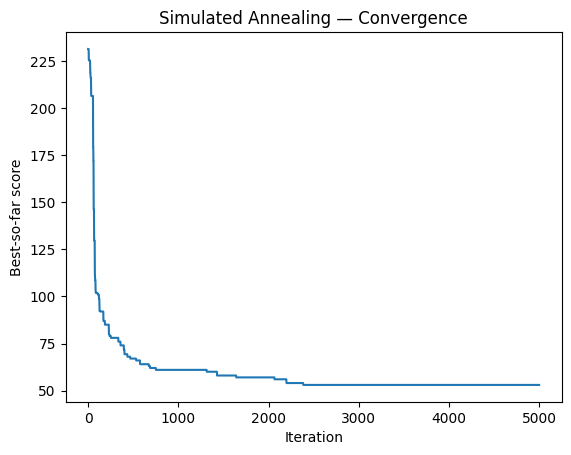

In [9]:
plt.figure()
plt.plot(hist_sa)
plt.xlabel("Iteration")
plt.ylabel("Best-so-far score")
plt.title("Simulated Annealing — Convergence")
plt.show()


## 7) Comparaison avec Monte Carlo Random Search

On ré-exécute rapidement Monte Carlo Random Search avec le même budget d’évaluations
et on compare les meilleurs scores obtenus.


In [10]:
def mc_random_search(instance, K=5000, seed=0, alpha=1.0, beta=0.2, gamma=0.0):
    rng = random.Random(seed)

    best_sol = None
    best_met = None
    best_score = float("inf")
    history = []

    start_time = time.time()

    for _ in range(K):
        sol = random_solution(instance, rng)
        score, met = compute_score(instance, simulate(instance, sol), alpha, beta, gamma)
        if score < best_score:
            best_score = score
            best_sol = sol
            best_met = met
        history.append(best_score)

    elapsed = time.time() - start_time
    return best_sol, best_met, history, elapsed

best_sol_mc, best_met_mc, hist_mc, elapsed_mc = mc_random_search(
    instance, K=5000, seed=0, alpha=alpha, beta=beta, gamma=gamma
)

print("MC elapsed (s):", round(elapsed_mc, 3))
print("Best MC metrics:", best_met_mc)


MC elapsed (s): 0.633
Best MC metrics: {'Cmax': 98.0, 'sumT': 83.80027928101104, 'sumWT': 0.0, 'score': 114.76005585620221}


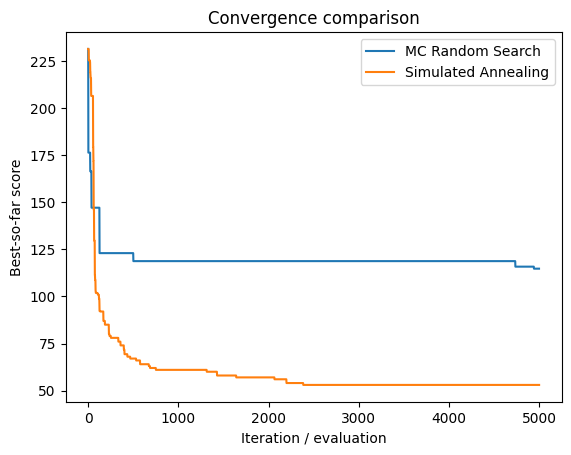

In [11]:
plt.figure()
plt.plot(hist_mc, label="MC Random Search")
plt.plot(hist_sa, label="Simulated Annealing")
plt.xlabel("Iteration / evaluation")
plt.ylabel("Best-so-far score")
plt.title("Convergence comparison")
plt.legend()
plt.show()


## 8) Sauvegarde du meilleur planning (SA)

On sauvegarde la meilleure solution trouvée et ses métriques
dans `data/results/`.


In [12]:
out = {
    "method": "simulated_annealing",
    "instance": instance["name"],
    "params": {"n_iters": 5000, "T0": 1.0, "cooling": 0.995, "seed": 0, "alpha": alpha, "beta": beta, "gamma": gamma},
    "best_metrics": best_met_sa,
    "best_solution": best_sol_sa
}

out_path = RESULTS_DIR / f"best_sa_{instance['name']}.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("Saved:", out_path)


Saved: /content/data/results/best_sa_instance_50jobs_5machines.json


## 9) Analyse et conclusion

La figure de comparaison des courbes de convergence met clairement en évidence
la différence de comportement entre **Monte Carlo Random Search** et le
**recuit simulé (Simulated Annealing)**.

La méthode Monte Carlo Random Search améliore rapidement la solution initiale,
mais atteint très vite un **palier**, au-delà duquel les améliorations deviennent
rares. Cette stagnation est due au fait que chaque échantillon est généré de manière
indépendante, sans exploiter l’information contenue dans les meilleures solutions
déjà trouvées.

À l’inverse, le recuit simulé présente une **convergence plus rapide et plus profonde**.
Grâce à l’exploration locale par voisinages et à l’acceptation probabiliste de solutions
dégradées, l’algorithme parvient à :
- échapper aux minima locaux,
- exploiter progressivement les bonnes régions de l’espace des solutions,
- atteindre des solutions de bien meilleure qualité.

Sur l’instance testée (50 tâches, 5 machines), le recuit simulé atteint un score final
de **53**, correspondant à un makespan minimal et à un retard nul, alors que
Monte Carlo Random Search se stabilise autour d’un score nettement plus élevé
(≈ 115).

Ces résultats confirment que le recuit simulé peut être interprété comme une
**méthode Monte Carlo guidée**, combinant exploration aléatoire et exploitation locale.
Il constitue ainsi une amélioration significative par rapport à l’échantillonnage
Monte Carlo pur pour les problèmes d’ordonnancement.
